# Мастерская

<b>Общая информация</b>

<font color='red'></font>
<b>Заказчик:</b>

Компания GoProtect

<b>Описание проекта:</b>

Сервис  “Мой Чемпион” помогает спортивным школам фигурного катания, тренерам мониторить результаты своих подопечных и планировать дальнейшее развитие спортсменов.

<b>Цель:</b>

Создать модель, помогающую находить элементы, которые могут быть успешно исполнены спортсменом на соревновании. Сервис будет прогнозировать прогресс и возможное выполнение тех или иных элементов программы по истории предыдущих выступлений и выполнения элементов на соревнованиях.

## Подготовительные операции

### Установка библиотек

In [5]:
!pip install lightgbm -U -q
!pip install pdfplumber -U -q
!pip install iterative-stratification -U -q
!pip install phik -U -q

### Импорт библиотек

In [7]:
import os
import sys
import warnings
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import pdfplumber
import unicodedata

from datetime import datetime
from colorama import Back, Fore, Style
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import f1_score, classification_report
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.multioutput import MultiOutputClassifier
from lightgbm import LGBMClassifier

### Загрузка csv файлов

In [9]:
units = pd.read_csv('units.csv')
tournaments = pd.read_csv('tournaments.csv')
total_scores = pd.read_csv('total_scores.csv')
tournament_scores = pd.read_csv('tournament_scores.csv')

### Задание констант

In [11]:
RANDOM = 12345
ADD_INFO_DIR = "."
ELEMS_FILE = "elements.pdf"

## Ознакомление с данными

In [13]:
# Вывод первых 5 строк DataFrame
print(units.head())

     id  color  school_id
0  9474  green      244.0
1   733  green      203.0
2   734  green      235.0
3   735  green      168.0
4   736  green      168.0


In [14]:
print(units.tail())

         id  color  school_id
4591  10122  green      198.0
4592   5108  green       62.0
4593   5109  green       27.0
4594   5110  green       62.0
4595   5113  green       62.0


In [15]:
print(tournaments.head())

   id  date_start    date_end  origin_id
0   1  2090-11-29  2090-12-01        2.0
1   2  2091-03-06  2091-03-10        1.0
2   3  2090-10-05  2090-10-08        2.0
3   4  2090-10-18  2090-10-21        2.0
4   5  2090-10-21  2090-10-24        2.0


In [16]:
print(tournaments.tail())

       id  date_start    date_end  origin_id
137  7114  2092-04-15  2092-04-20        1.0
138  7116  2091-10-24  2091-10-27        0.0
139  7117  2092-04-29  2092-05-03        0.0
140  7115  2092-04-23  2092-04-26        2.0
141  6676  2092-02-28  2092-03-01        1.0


In [17]:
pd.set_option('display.max_columns', None)
print(total_scores.head())

       id  unit_id  tournament_id  base_score  components_score  total_score  \
0  442027      304           4785        47.2             43.47       102.70   
1  442028      604           4785        45.4             46.71       101.19   
2  442029      409           4785        44.0             46.82        99.20   
3  442030      524           4785        46.2             44.86        91.84   
4  442031      412           4785        44.2             42.59        89.73   

   elements_score  decreasings_score  starting_place  place  \
0           59.23                0.0              17      1   
1           54.48                0.0              18      2   
2           52.38                0.0               6      3   
3           47.98               -1.0               3      4   
4           48.14               -1.0              15      5   

         segment_name                                               info  \
0  Короткая программа  x Надбавка за прыжки во второй половине п

In [18]:
print(total_scores.tail())

           id  unit_id  tournament_id  base_score  components_score  \
21296  462405    34979           7116       21.67             26.02   
21297  462406     1995           7116       23.20             25.50   
21298  462407    34841           7116       21.83             25.00   
21299  462408    34980           7116       21.17             26.00   
21300  462409     9973           7116       18.91             25.00   

       total_score  elements_score  decreasings_score  starting_place  place  \
21296        46.62           21.10               -0.5               6     20   
21297        46.22           21.22               -0.5               7     21   
21298        45.46           20.96               -0.5               5     22   
21299        45.24           20.74               -1.5               2     23   
21300        43.05           18.55               -0.5               8     24   

                 segment_name  \
21296  Произвольная программа   
21297  Произвольная програ

In [19]:
print(tournament_scores.head())

   id  total_score_id   title decrease  base_score   goe  avg_score
0   1               1      2A      NaN         3.3  0.66       3.96
1   2               1  3F+3Lo      NaN        10.2 -0.11      10.09
2   3               1     3Lz      NaN         0.0 -1.30       5.19
3   4               1  CCoSp4      NaN         3.5  0.56       4.06
4   5               1   FCSp4      NaN         3.2  0.64       3.84


In [20]:
print(tournament_scores.tail())

            id  total_score_id   title decrease  base_score   goe  avg_score
172153  352008          463407  CCoSp3      NaN         3.0  0.60       3.60
172154  352009          463407     2Lz      NaN         2.1  0.00       2.10
172155  352010          463407     2Lo      NaN         1.7  0.23       1.93
172156  352011          463407   StSq2      NaN         2.6  0.52       3.12
172157  352012          463407   FSSp3      NaN         2.6  0.26       2.86


In [21]:
units.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4596 entries, 0 to 4595
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         4596 non-null   int64  
 1   color      4595 non-null   object 
 2   school_id  4007 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 107.8+ KB


In [22]:
tournaments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          142 non-null    int64  
 1   date_start  142 non-null    object 
 2   date_end    142 non-null    object 
 3   origin_id   142 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ KB


In [23]:
total_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21301 entries, 0 to 21300
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21301 non-null  int64  
 1   unit_id              21301 non-null  int64  
 2   tournament_id        21301 non-null  int64  
 3   base_score           21301 non-null  float64
 4   components_score     21301 non-null  float64
 5   total_score          21301 non-null  float64
 6   elements_score       21301 non-null  float64
 7   decreasings_score    21301 non-null  float64
 8   starting_place       21301 non-null  int64  
 9   place                21301 non-null  int64  
 10  segment_name         21284 non-null  object 
 11  info                 20720 non-null  object 
 12  overall_place        21301 non-null  int64  
 13  overall_total_score  21284 non-null  float64
 14  overall_place_str    10814 non-null  object 
dtypes: float64(6), int64(6), object(3)
m

In [24]:
tournament_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              172158 non-null  int64  
 1   total_score_id  172158 non-null  int64  
 2   title           172158 non-null  object 
 3   decrease        41185 non-null   object 
 4   base_score      172158 non-null  float64
 5   goe             172158 non-null  float64
 6   avg_score       172158 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 9.2+ MB


## Графический анализ данных

### Функция для гистограммы встречаемости признака и боксплота

In [27]:
def plotandbox(data, feature, hist_color='darkslategray', rotate_labels=False, rotation_angle=45):
    fig, axs = plt.subplots(nrows = 1 , ncols = 2, figsize = (12, 4))
    sns.histplot(data = data, x = feature, ax=axs[0], bins = 50, kde=True, color=hist_color, edgecolor='black')
    axs[0].set_xlabel(feature)
    axs[0].set_ylabel('частота')
    sns.boxplot(data = data, x = feature, ax=axs[1], color='azure')
    axs[1].set_xlabel(feature)
    if rotate_labels:
        for ax in axs:
            ax.tick_params(axis='x', rotation=rotation_angle)
    fig.suptitle(f'Анализ распределения {feature}')
    plt.show()

### Анализ признаков датафрейма units

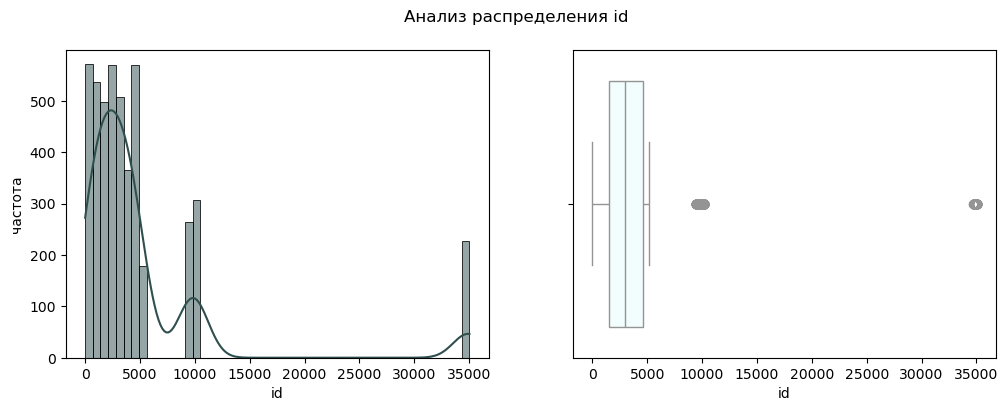

In [29]:
plotandbox(units, 'id')

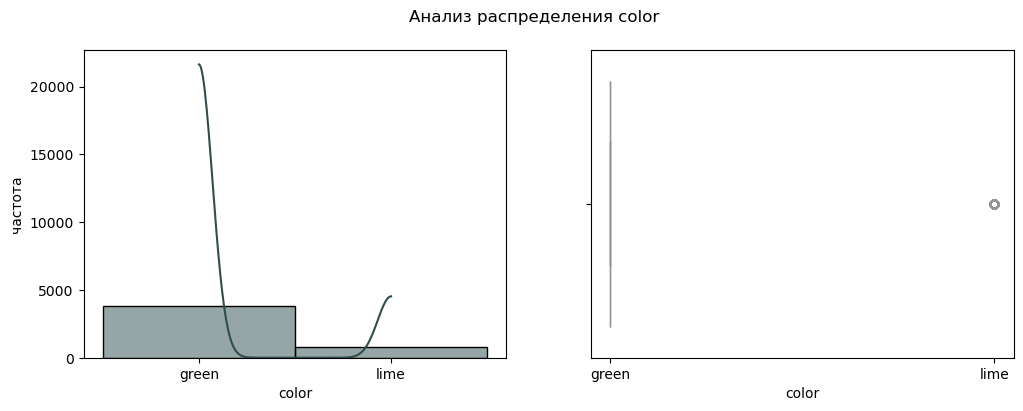

In [30]:
plotandbox(units, 'color')

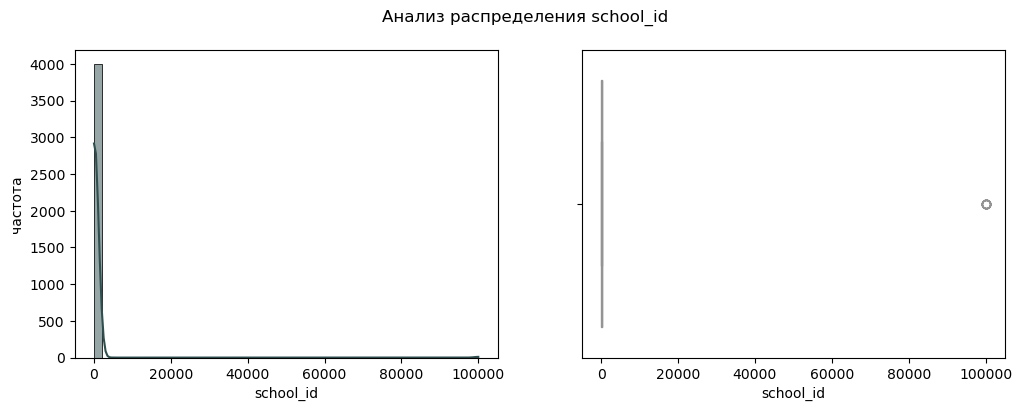

In [31]:
plotandbox(units, 'school_id')

Изучим непонятный выброс в датасете units на 'school_id' = 100000 и посмотрим станет ли лучше боксплот без него

In [33]:
max_school_id = units['school_id'].max()
filtered_series = units[units['school_id'] <= max_school_id]['school_id'].sort_values(ascending=False).head(15)
print("\\nПоследние 5 значений 'school_id' (максимальное значение и 4 предыдущих):")
print(filtered_series)

\nПоследние 5 значений 'school_id' (максимальное значение и 4 предыдущих):
1917    99999.0
730     99999.0
2290    99999.0
712     99999.0
1492    99999.0
713     99999.0
775     99999.0
1463    99999.0
741     99999.0
1838    99999.0
68      99999.0
711     99999.0
717     99999.0
2711      305.0
2745      305.0
Name: school_id, dtype: float64


Совершенно не понятно что это за 13 значений со 'school_id' = 99999. Возможно какие то тестовые выступления. Имеем право их удалить так как их доля в общем пуле значений 'school_id' менее процента. Это нужно что бы расследовать были ли школы от которых выступали чаще других. Возможно имеется какой-либо субъективный фактор связанный той или иной школой при различных условиях, влияющий на качество выступления фигуристов либо на завышение/занижение субъективной оценки жюри (если такое возможно).

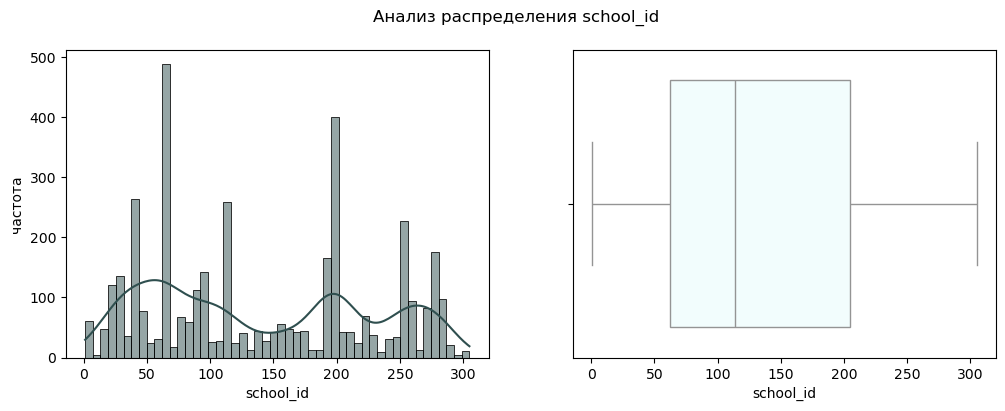

In [35]:
units.drop(units[units['school_id'] == 99999].index, inplace=True)
plotandbox(units, 'school_id')

Боксплот без выбросов. И видно что от нескольких школ выступали чаще других. Возможно какие то школы готовять большее число спортсменов (не обязательно по казывающих выдающиеся результаты). Более глубокие изыскания проведем позднее.

### Анализ признаков датафрейма tournaments

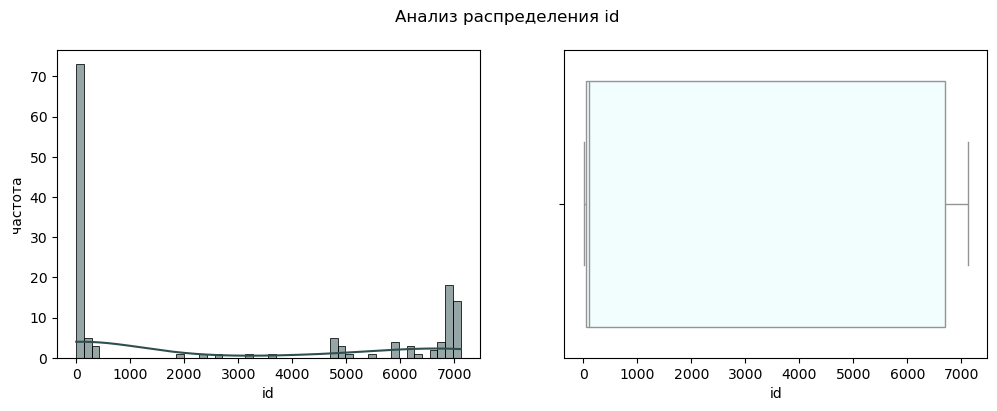

In [38]:
plotandbox(tournaments, 'id')

Видим большое количество нулевых значений id (турнира) это может говорить о том что

Предварительно преобразуем дату из объектного типа в тип datetime64

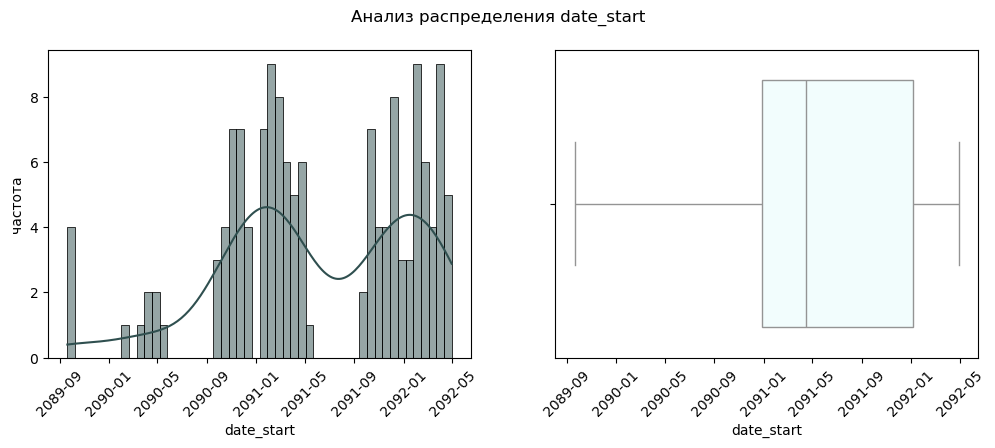

In [41]:
tournaments['date_start'] = pd.to_datetime(tournaments['date_start'])
plotandbox(tournaments, 'date_start', rotate_labels=True, rotation_angle=45)

Делаем схожее преобразование для даты окончания соревнований

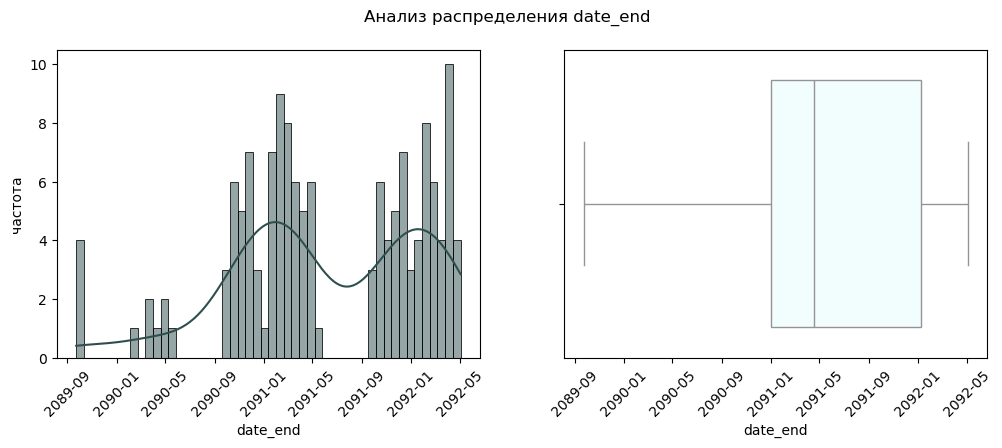

In [43]:
tournaments['date_end'] = pd.to_datetime(tournaments['date_end'])
plotandbox(tournaments, 'date_end', rotate_labels=True, rotation_angle=45)

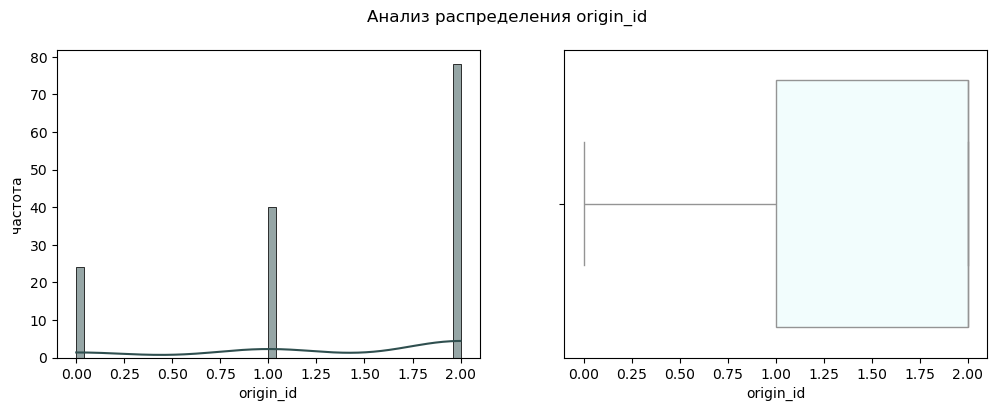

In [44]:
plotandbox(tournaments, 'origin_id')

### Анализ признаков датафрейма total_scores

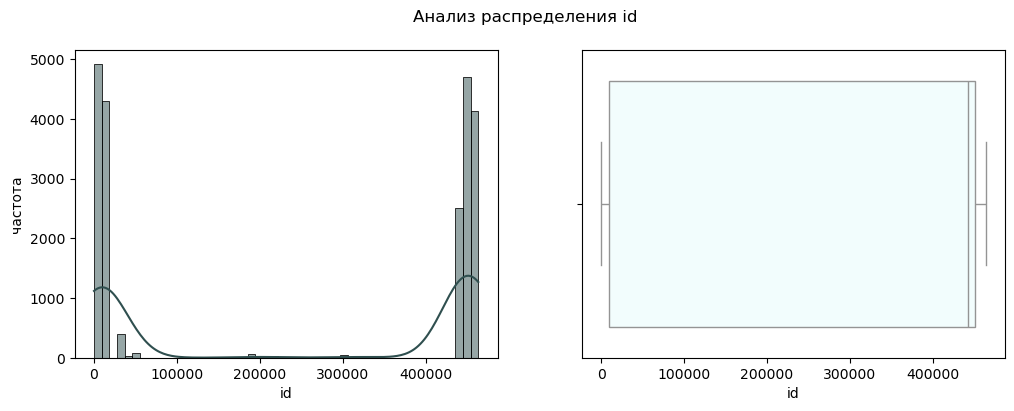

In [46]:
plotandbox(total_scores, 'id')

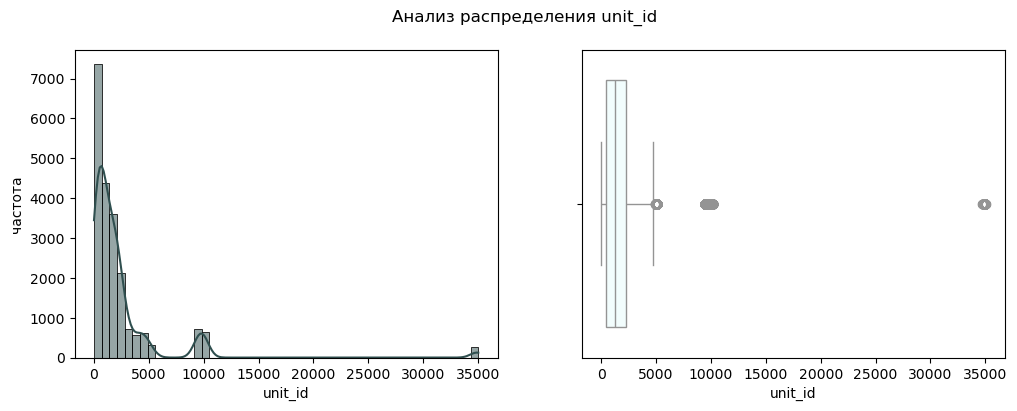

In [47]:
plotandbox(total_scores, 'unit_id')

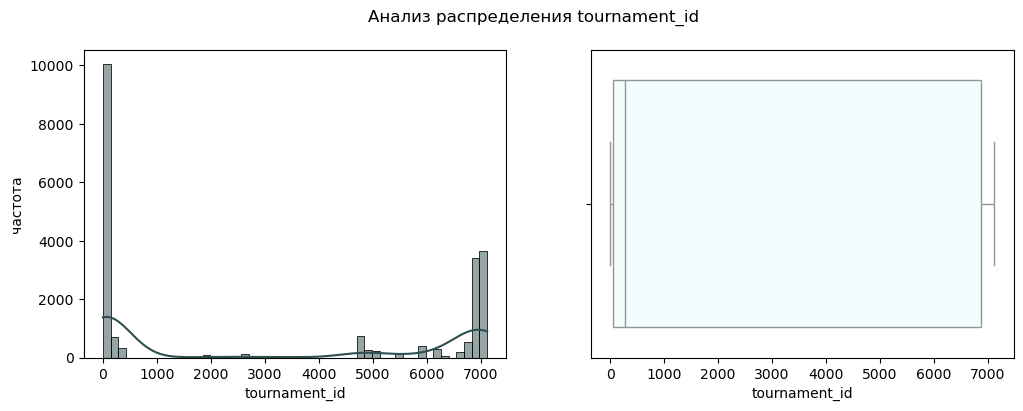

In [48]:
plotandbox(total_scores, 'tournament_id')

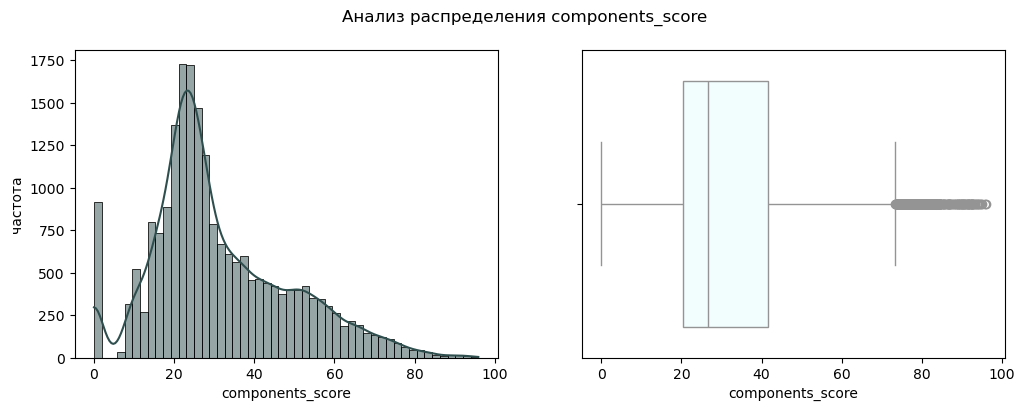

In [49]:
plotandbox(total_scores, 'components_score')

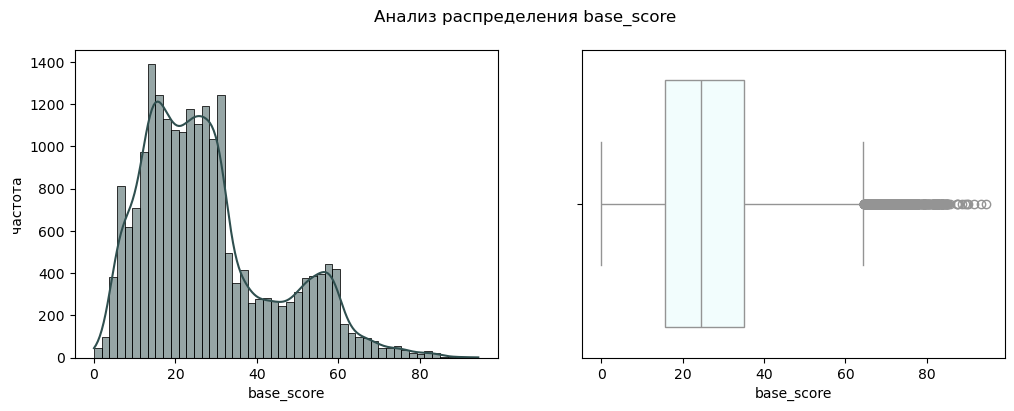

In [50]:
plotandbox(total_scores, 'base_score')

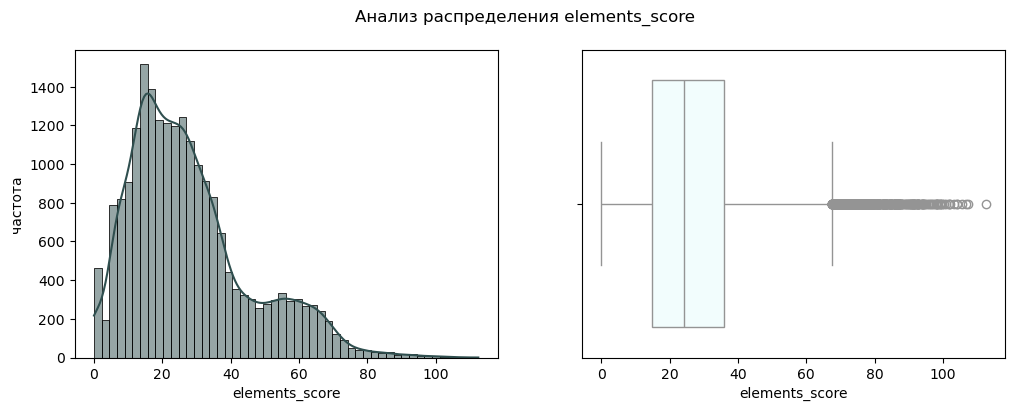

In [51]:
plotandbox(total_scores, 'elements_score')

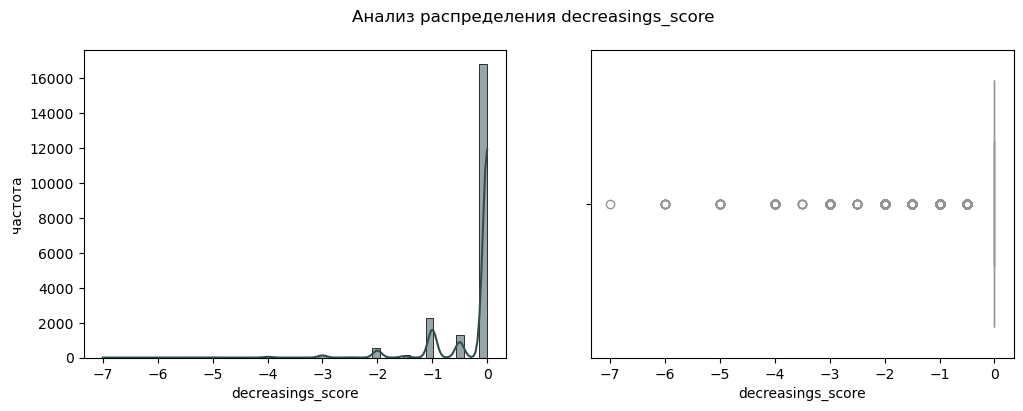

In [52]:
plotandbox(total_scores, 'decreasings_score')

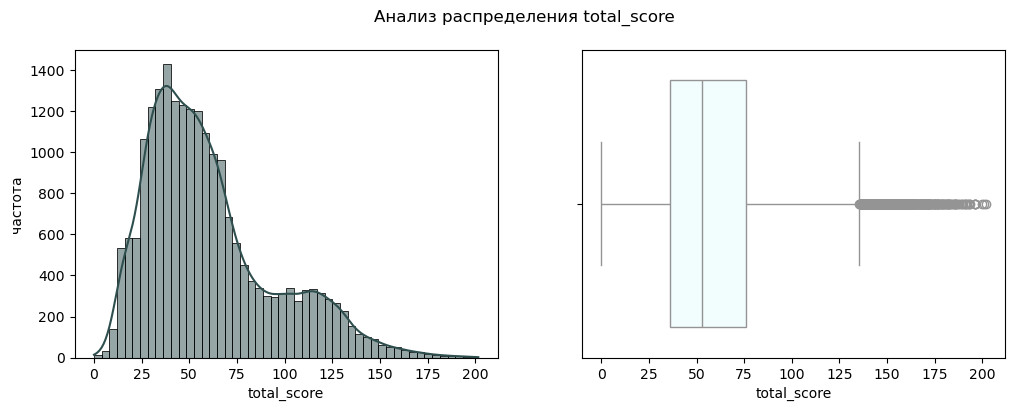

In [53]:
plotandbox(total_scores, 'total_score')

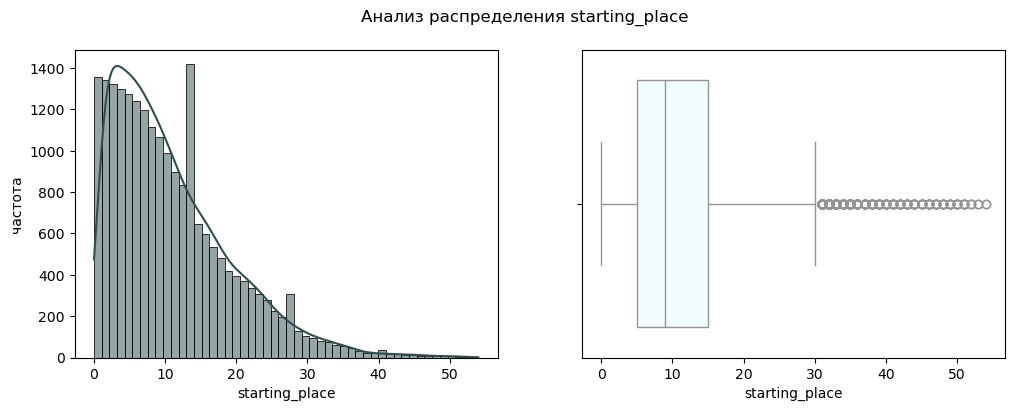

In [54]:
plotandbox(total_scores, 'starting_place')

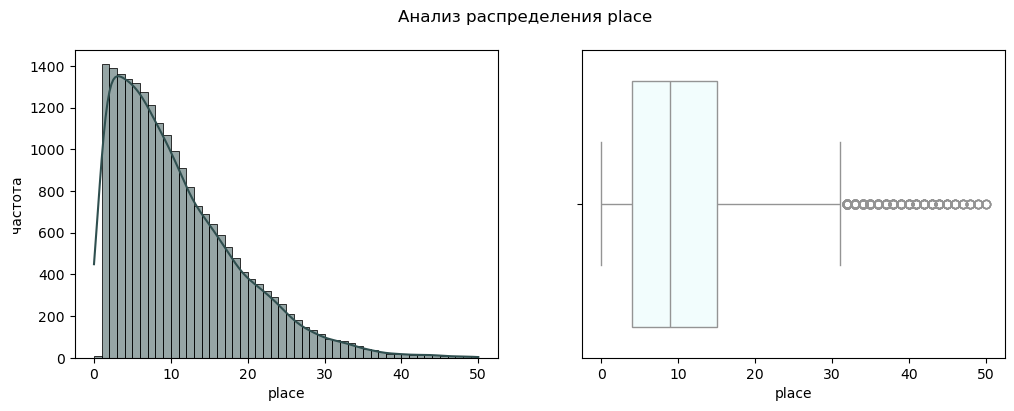

In [55]:
plotandbox(total_scores, 'place')

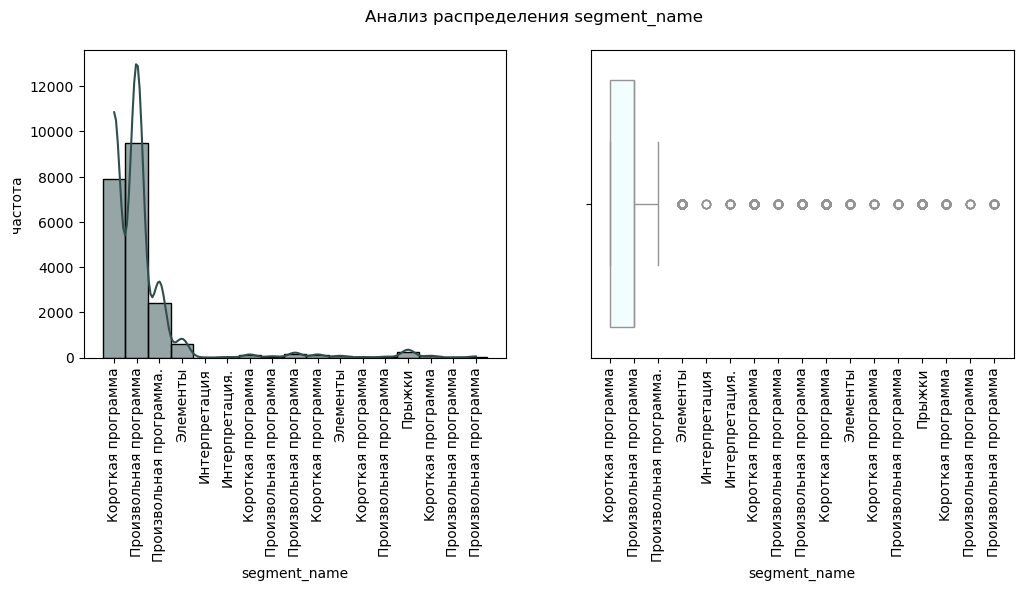

In [56]:
plotandbox(total_scores, 'segment_name', rotate_labels=True, rotation_angle=90)

Признак "info" для графика не слишком информативен. Не будем его отображать на графике.

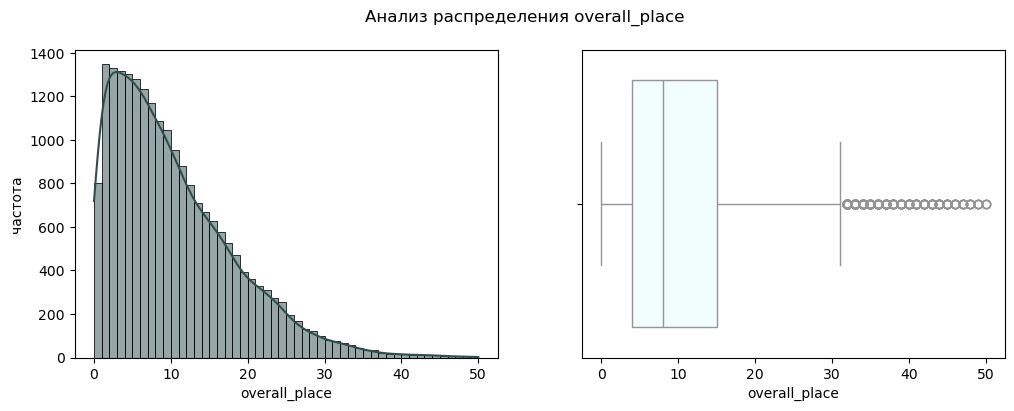

In [58]:
plotandbox(total_scores, 'overall_place')

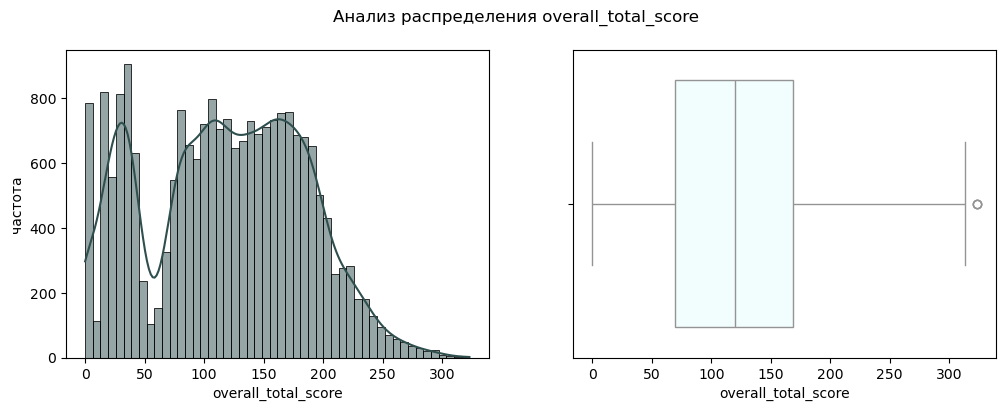

In [59]:
plotandbox(total_scores, 'overall_total_score')

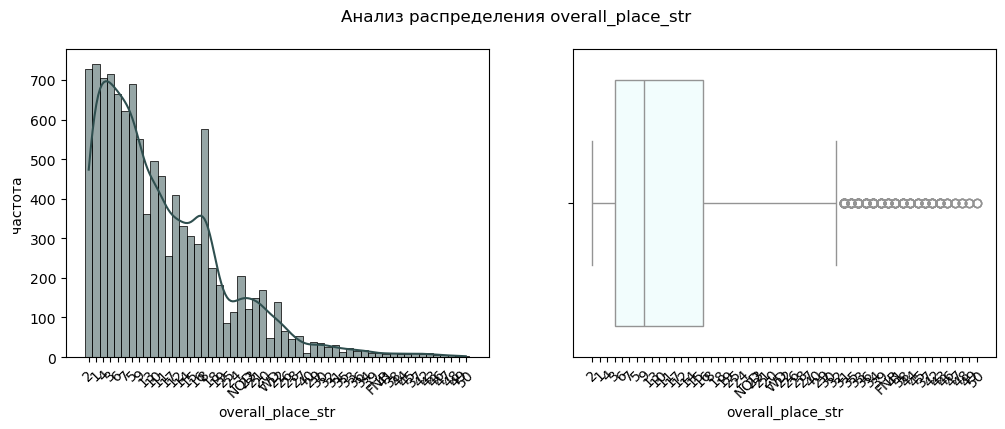

In [60]:
plotandbox(total_scores, 'overall_place_str', rotate_labels=True, rotation_angle=45)

### Анализ признаков датафрейма tournament_scores

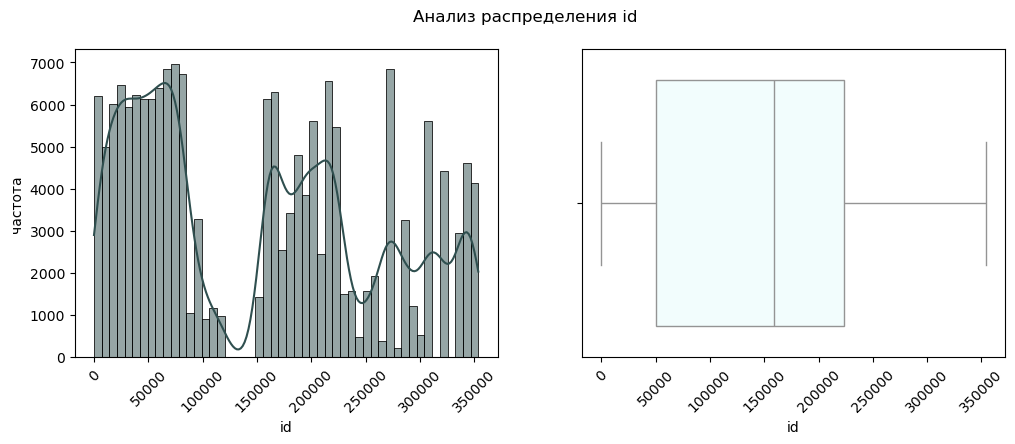

In [62]:
plotandbox(tournament_scores, 'id', rotate_labels=True, rotation_angle=45)

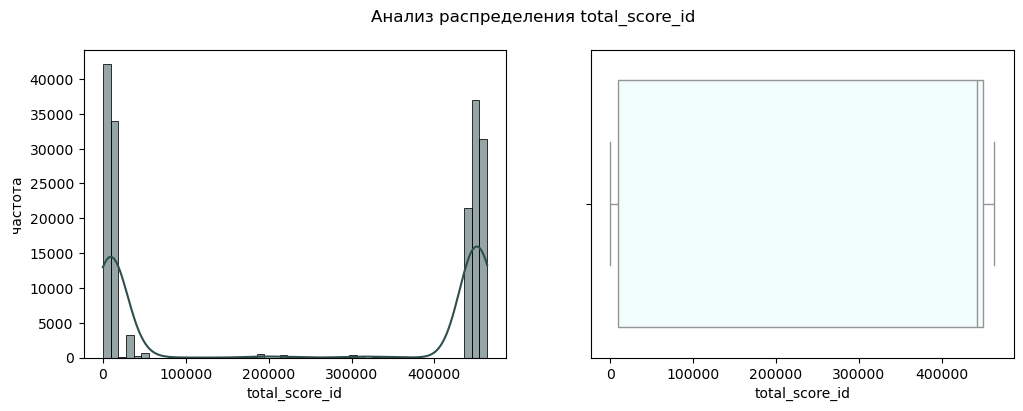

In [63]:
plotandbox(tournament_scores, 'total_score_id')

Обозначения на оси абсцисс не читабельны, т.к. сливаются. Переделка подписей под углом не спасет ситуацию. Для сохранения быстроты расчетов не будем пока отображать эти графики

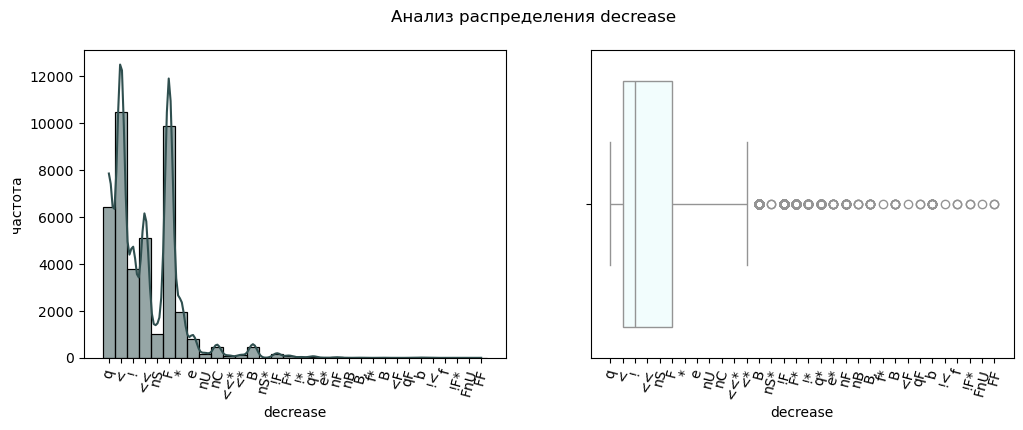

In [65]:
plotandbox(tournament_scores, 'decrease', rotate_labels=True, rotation_angle=75)

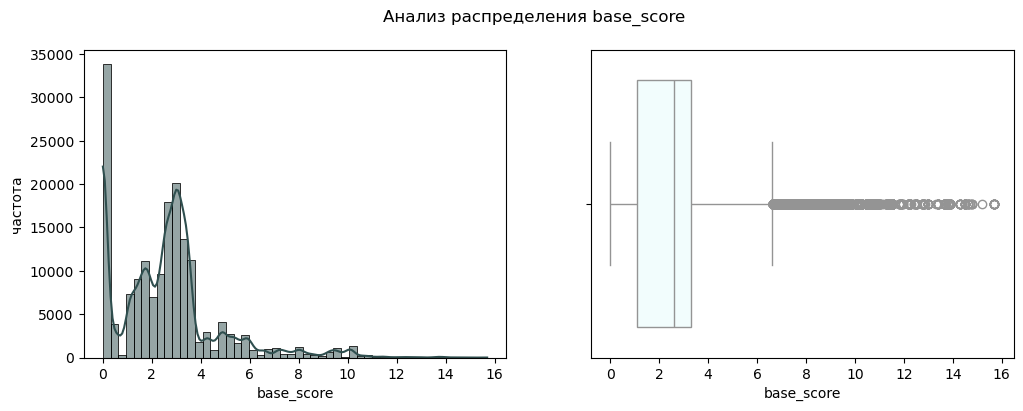

In [66]:
plotandbox(tournament_scores, 'base_score')

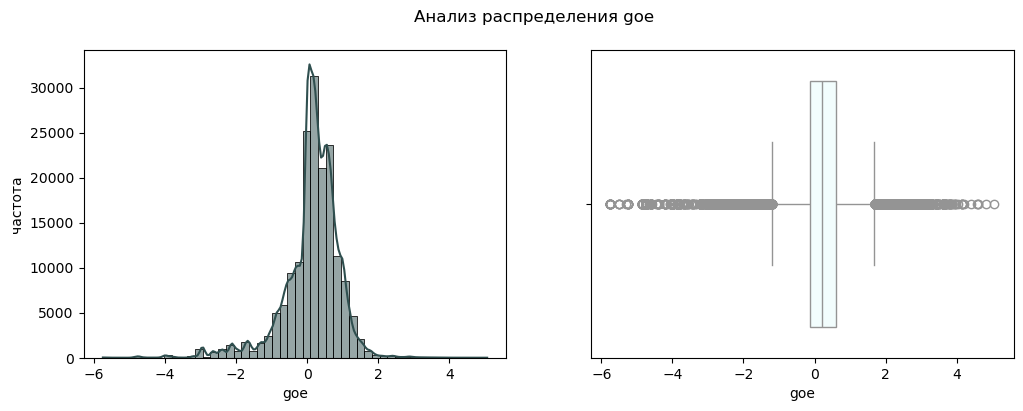

In [67]:
plotandbox(tournament_scores, 'goe')

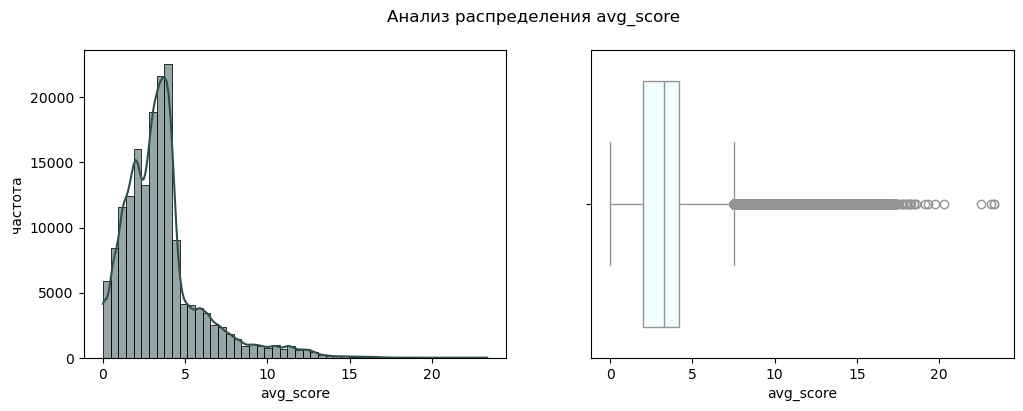

In [68]:
plotandbox(tournament_scores, 'avg_score')

Не будем пока что удалять значения не входящие не межквартильный интервал попробуем слить данные.

## Изменение структуры датасетов

### Функция слияние датасетов

In [72]:
def burgermerger(total_scores, tournament_scores, tournaments, units):
    
    # Переименование столбцов для объединения
    total_scores = total_scores.rename(columns={"id": "total_score_id"})
    tournament_scores = tournament_scores.rename(columns={"id": "tournament_scores_id"})
    tournaments = tournaments.rename(columns={"id": "tournament_id"})
    units = units.rename(columns={"id": "unit_id"})

    # Слияние
    data = total_scores.merge(tournament_scores, on="total_score_id", how="inner")
    data = data.merge(units, on="unit_id", how="inner")
    data = data.merge(tournaments, on="tournament_id", how="inner")

    # Переименование дублированных столбцов после слияния
    data = data.rename(columns={"base_score_x": "base_score", "base_score_y": "base_score_elements"})
    
    # Выберем нужные столбцы
    cols_structure = ["total_score_id", "unit_id", "color", "tournament_id", "date_start", "date_end", "origin_id", "base_score", "components_score", 
                      "total_score", "elements_score", "decreasings_score", "starting_place", "place", "segment_name", "info", "overall_place", 
                      "overall_total_score", "title", "decrease", "base_score_elements", "goe", "avg_score"]

    # Отсортируем датафрейм по дате начала
    data = data[cols_structure]
    data = data.sort_values(by="date_start", ascending=True)

    # Внесём единобразие в названия сегментов
    data.loc[data["segment_name"].isin(["Короткая программа", "Кoроткая программа", "Кopoткaя пpoгpaммa", "Kopoткaя пpoгpaммa",
                                        "Коpоткая программа"]), "segment_name"] = "Короткая программа"
    data.loc[data["segment_name"].isin(["Произвольная программа", "Произвольная программа.", "Произвольнaя программа", "Пpoизвoльнaя пpoгpaммa", 
                                        "Прoизвольная прoграмма", "Пpoизвольная программа", "Пpoизвольнaя программа"]),
                                        "segment_name"] = "Произвольная программа"
    data.loc[data["segment_name"].isin(["Интерпретация.", "Интерпретация'"]), "segment_name"] = "Интерпретация"
    data.loc[data["segment_name"].isin(["Элементы", "Элeмeнты"]), "segment_name"] = "Элементы"

    # Остаются строки с короткой и произвольной программой
    data = data[(data["segment_name"] == "Короткая программа") | (data["segment_name"] == "Произвольная программа")]
    
    grouped = data.groupby(["unit_id", "tournament_id"])

    # сформируем и применим маску в которой оставляем строки в которых есть и короткая и произвольная программы
    mask = grouped["segment_name"].transform(lambda x: set(x).issuperset({"Короткая программа", "Произвольная программа"}))
    data = data[mask]
    return data

In [73]:
data = burgermerger(total_scores, tournament_scores, tournaments, units)

### Функция транслитерации

In [75]:
def convert_to_latin(string):
    mapping = {"А":"A","а":"a","О":"O","о":"o","Е":"E","е":"e","С":"C","с":"c","Т":"T","М":"M","Р":"P","р":"p","Х":"X","х":"x"}
    return ''.join([mapping.get(char, char) for char in string])

### Функция парсинга PDF файла содержащего оценки элементов

In [77]:
def parse_pdf(pdf_dir=None, file=None, convert_to_latin=None):
    if any(param is None for param in [pdf_dir, file, convert_to_latin]): raise ValueError("Все параметры должны быть указаны") # Проверка данных
    file_path = os.path.join(pdf_dir, file)
    result_data = []

    with pdfplumber.open(file_path) as pdf_object: # Обработка первых 6 страниц документа
        for page_number in range(1, 7):
            current_page = pdf_object.pages[page_number]
            extracted_tables = current_page.extract_tables()[1:]
            flat_table = [item for table in extracted_tables for item in table] # Преобразование вложенных списков в плоский список
            result_data.extend(flat_table)

    score_mapping = {}
    for entry in result_data:
        key = entry[0]
        raw_values = entry[1:]
        cleaned_values = [v.replace(",", ".") for v in raw_values]  # Очистка и преобразование значений
        numeric_values = [float(v) for v in cleaned_values if v]
        if numeric_values: score_mapping[key] = max(numeric_values)

    # Добавление дополнительных элементов
    additional_elements = {
        "1W": 0.2, "ChSq": 0.0, "ChSq1*": 0.0, "ChSpl1": 1.5, "ChSpl": 0.0,
        "FSSp": 0.0, "CCSp": 0.0, "FCSp": 0.0, "CSSp": 0.0, "CoSp": 0.0,
        "Sp": 0.0, "CSp": 0.0, "SSp": 0.0, "FCCoSp": 0.0, "CCoSp": 0.0,
        "CCoSpV": 0.0, "FCSSp": 0.0, "FCoSp": 0.0, "FSsp2": 0.0,
        "LSp": 0.0, "StSq": 0.0
    }
    score_mapping.update(additional_elements)
    converted_scores = {convert_to_latin(k): v for k, v in score_mapping.items()} # Конвертация ключей
    return converted_scores

### Функция для очистки и нормализации названий элементов

In [79]:
def clean_elements(row):
    # Конфигурация
    KEEP_Q_ELEMENTS = {"ChSq1", "ChSq", "ChSq1*", "ChSpl1", "ChSpl", "StSqB", "StSq1", "StSq2", "StSq3", "StSq4", "StSq"}
    REMOVE_PATTERNS = ["*", "<", "<<", "e", "!"]
    REMOVE_SUFFIXES = ["+COMBO", "+SEQ", "+SЕQ", "+REP"]
    SINGLE_ELEMENTS = {"T": "1T", "S": "1S", "F": "1F", "A": "1A", "Lz": "1Lz", "Lo": "1Lo"}
    
    if not any(el in row for el in KEEP_Q_ELEMENTS): row = row.replace("q", "")  # Удаление "q" если не в исключениях
    for pattern in REMOVE_PATTERNS: row = row.replace(pattern, "")               # Удаление ненужных символов
    for suffix in REMOVE_SUFFIXES: row = row.replace(suffix, "")                 # Удаление суффиксов

    def normalize_single(element): return SINGLE_ELEMENTS.get(element, element)  # Обработка одиночных элементов

    if "+" in row:
        # Обработка комбинаций
        elements = row.split("+")
        normalized = [normalize_single(e) for e in elements]
        row = "+".join(normalized)
    else:
        row = normalize_single(row) # Вызов функции обработки одиночных элементов

    row = convert_to_latin(row) # Конвертация в латиницу
    return row

### Функция для вычисления максимального базового балла элемента

In [81]:
def max_base_score_for_clean_elements(row, elem_base_scores): 
    return sum(map(elem_base_scores.get, row.split("+"))) if "+" in row else elem_base_scores[row]

In [82]:
elem_base_scores = parse_pdf(pdf_dir=ADD_INFO_DIR, file=ELEMS_FILE, convert_to_latin=convert_to_latin)

In [83]:
formatted_output = ", ".join([f"'{key}': {value}" for key, value in elem_base_scores.items()])
print(formatted_output)

'1T': 0.4, '1S': 0.4, '1Lo': 0.5, '1Eu': 0.5, '1F': 0.5, '1Lz': 0.6, '1Tq': 0.4, '1Sq': 0.4, '1Loq': 0.5, '1Fq': 0.5, '1Lzq': 0.6, '1T<': 0.32, '1S<': 0.32, '1Lo<': 0.4, '1F<': 0.4, '1Lz<': 0.48, '1T<<': 0.0, '1S<<': 0.0, '1Lo<<': 0.0, '1Eu<<': 0.0, '1F<<': 0.0, '1Lz<<': 0.0, '1Fe': 0.4, '1Feq': 0.4, '1Fe<': 0.3, '1Fe<<': 0.0, '1Lze': 0.48, '1Lzeq': 0.48, '1Lze<': 0.36, '1Lze<<': 0.0, '1F!': 0.5, '1F!q': 0.5, '1F!<': 0.4, '1F!<<': 0.0, '1Lz!': 0.6, '1Lz!q': 0.6, '1Lz!<': 0.48, '1Lz!<<': 0.0, '1A': 1.1, '2T': 1.3, '2S': 1.3, '2Lo': 1.7, '2F': 1.8, '2Lz': 2.1, '1Aq': 1.1, '2Tq': 1.3, '2Sq': 1.3, '2Loq': 1.7, '2Fq': 1.8, '2Lzq': 2.1, '1A<': 0.88, '2T<': 1.04, '2S<': 1.04, '2Lo<': 1.36, '2F<': 1.44, '2Lz<': 1.68, '1A<<': 0.0, '2T<<': 0.4, '2S<<': 0.4, '2Lo<<': 0.5, '2F<<': 0.5, '2Lz<<': 0.6, '2Fe': 1.44, '2Feq': 1.44, '2Fe<': 1.08, '2Fe<<': 0.4, '2Lze': 1.68, '2Lzeq': 1.68, '2Lze<': 1.26, '2Lze<<': 0.48, '2F!': 1.8, '2F!q': 1.8, '2F!<': 1.44, '2F!<<': 0.5, '2Lz!': 2.1, '2Lz!q': 2.1, '2Lz!<

In [84]:
data["clean_elems"] = data["title"].apply(clean_elements)

In [85]:
data["max_base_score"] = data["clean_elems"].apply(max_base_score_for_clean_elements, elem_base_scores=elem_base_scores)

In [87]:
agg_dict = {
    "date_start": ("date_start", "first"),
    "color": ("color", lambda x: x.mode().iat[0]),
    "origin_id": ("origin_id", "max"),
    "base_score_free": ("base_score", "max"),
    "base_score_short": ("base_score", "min"),
    "components_score_free": ("components_score", "max"),
    "components_score_short": ("components_score", "min"),
    "total_score_free": ("total_score", "max"),
    "total_score_short": ("total_score", "min"),
    "elements_score_free": ("elements_score", "max"),
    "elements_score_short": ("elements_score", "min"),
    "place_free": ("place", "max"),
    "place_short": ("place", "min"),
    "overall_place": ("overall_place", "max"),
    "overall_total_score": ("overall_total_score", "max"),
    "max_base_score_total": ("max_base_score", "sum"),
    "goe_total": ("goe", "sum"),
    "title": ("title", lambda x: "+".join(x)),
    "clean_title": ("clean_elems", lambda x: "+".join(x)),
}

In [88]:
data_agg = data.groupby(["unit_id", "tournament_id"]).agg(**agg_dict).reset_index()

In [89]:
data_agg.sample(10)

,unit_id,tournament_id,date_start,color,origin_id,base_score_free,base_score_short,components_score_free,components_score_short,total_score_free,total_score_short,elements_score_free,elements_score_short,place_free,place_short,overall_place,overall_total_score,max_base_score_total,goe_total,title,clean_title
1922,392,3,2090-10-05,green,2.0,59.27,31.51,59.14,26.99,127.10,59.01,67.96,32.02,11,7,9,186.11,88.7,9.20,3Lz+3T+3F+3Lo+2A+FSSp3+StSq2+2Aq+1Eu+3S<+3Lz+3...,3Lz+3T+3F+3Lo+2A+FSSp3+StSq2+2A+1Eu+3S+3Lz+3Lo...
3657,847,176,2091-03-21,lime,2.0,55.13,27.03,54.94,31.31,107.07,62.31,54.13,32.00,5,5,5,169.38,81.2,3.97,3F+CCoSp3+FCSp4+3T+2T+3Lo+ChSq1+CSSp4+3Lz+3S+2...,3F+CCoSp3+FCSp4+3T+2T+3Lo+ChSq1+CSSp4+3Lz+3S+2...
3602,834,24,2091-01-26,green,2.0,52.39,26.93,47.26,23.88,101.25,54.12,54.99,30.24,9,8,12,190.83,82.8,5.91,LSp4+ChSq1+FCCoSp3+3F+3Lo+3S+3F+2T+3Lo+2T+2A+S...,LSp4+ChSq1+FCCoSp3+3F+3Lo+3S+3F+2T+3Lo+2T+2A+2...
3981,934,22,2091-01-26,green,2.0,24.68,15.13,36.93,18.06,61.29,33.69,24.36,15.63,10,7,10,116.28,40.3,0.18,StSq2+CCoSp4+1A+2Lz<+2F+2Loq+LSp3+2F<+1A+2T<+S...,StSq2+CCoSp4+1A+2Lz+2F+2Lo+LSp3+2F+1A+2T+2S+CC...
5565,1855,6847,2091-11-01,green,0.0,23.66,13.60,25.84,14.54,50.39,28.53,25.05,13.99,10,10,10,78.92,36.9,1.78,2Lz+2F+1A+2T+SЕQ+ChSq1+FSSp3+2Lo<+2F+2Lz+2Lo+C...,2Lz+2F+1A+2T+ChSq1+FSSp3+2Lo+2F+2Lz+2Lo+CCoSp3...
6640,2450,93,2089-10-07,lime,1.0,61.71,31.73,84.00,41.50,159.32,82.63,75.32,0.00,3,1,1,241.95,91.3,22.01,3Lo+3Lz+StSq2+3F+3F+1Eu+2S+FCSp2+2A+3Lz+3T+CSS...,3Lo+3Lz+StSq2+3F+3F+1Eu+2S+FCSp2+2A+3Lz+3T+CSS...
670,138,78,2090-11-21,green,1.0,20.31,13.62,33.30,19.43,50.44,31.45,18.14,13.02,25,19,23,81.89,40.5,-2.77,StSqB+LSp3+CCoSp3+2Lz+2F!+COMBO+2A<+StSq1+CCoS...,StSqB+LSp3+CCoSp3+2Lz+2F+2A+StSq1+CCoSp3+2A+2A...
4549,1229,33,2091-02-21,green,2.0,59.80,31.49,60.51,29.82,132.51,68.28,72.00,38.46,1,1,1,200.79,88.8,19.17,FCSp4+3Lz+3S+2A+2T+SЕQ+3Lo+2T+ChSq1+3Lo+CCoSp4...,FCSp4+3Lz+3S+2A+2T+3Lo+2T+ChSq1+3Lo+CCoSp4+FCC...
2143,420,398,2091-10-03,lime,1.0,64.64,37.86,83.92,41.75,152.88,72.24,68.96,31.49,12,10,11,225.12,108.0,-2.05,4Lz<+2A+SЕQ+2Lz+3Lo+3F!+FSSp4+ChSq1+A+3A+1Eu+3...,4Lz+2A+2Lz+3Lo+3F+FSSp4+ChSq1+1A+3A+1Eu+3S+3Lz...
491,107,69,2091-04-18,green,1.0,22.67,13.35,28.00,14.43,50.96,28.62,23.46,14.19,11,10,11,79.58,36.5,1.63,2F+2S+FSSp3+2F!q+2Lo<+1A+SЕQ+ChSq1+2Lo+CCoSp3+...,2F+2S+FSSp3+2F+2Lo+1A+ChSq1+2Lo+CCoSp3+2Lz+2Lz...


### Словарь для аггрегации

In [91]:
final_agg_dict = {
    "tournaments": ("tournament_id", "count"),
    "color": ("color", lambda x: x.mode().iat[0]),
    "base_score_free_min": ("base_score_free", "min"),
    "base_score_free_max": ("base_score_free", "max"),
    "base_score_free_avg": ("base_score_free", "mean"),
    "base_score_short_min": ("base_score_short", "min"),
    "base_score_short_max": ("base_score_short", "max"),
    "base_score_short_avg": ("base_score_short", "mean"),
    "components_score_free_min": ("components_score_free", "min"),
    "components_score_free_max": ("components_score_free", "max"),
    "components_score_free_avg": ("components_score_free", "mean"),
    "components_score_short_min": ("components_score_short", "min"),
    "components_score_short_max": ("components_score_short", "max"),
    "components_score_short_avg": ("components_score_short", "mean"),
    "total_score_free_min": ("total_score_free", "min"),
    "total_score_free_max": ("total_score_free", "max"),
    "total_score_free_avg": ("total_score_free", "mean"),
    "total_score_short_min": ("total_score_short", "min"),
    "total_score_short_max": ("total_score_short", "max"),
    "total_score_short_avg": ("total_score_short", "mean"),
    "elements_score_free_min": ("elements_score_free", "min"),
    "elements_score_free_max": ("elements_score_free", "max"),
    "elements_score_free_avg": ("elements_score_free", "mean"),
    "elements_score_short_min": ("elements_score_short", "min"),
    "elements_score_short_max": ("elements_score_short", "max"),
    "elements_score_short_avg": ("elements_score_short", "mean"),
    "place_free_min": ("place_free", "max"),
    "place_free_max": ("place_free", "min"),
    "place_short_min": ("place_short", "max"),
    "place_short_max": ("place_short", "min"),
    "overall_place_min": ("overall_place", "max"),
    "overall_place_max": ("overall_place", "min"),
    "overall_total_score_min": ("overall_total_score", "min"),
    "overall_total_score_max": ("overall_total_score", "max"),
    "overall_total_score_avg": ("overall_total_score", "mean"),
    "max_base_score_total_min": ("max_base_score_total", "min"),
    "max_base_score_total_max": ("max_base_score_total", "max"),
    "goe_total_min": ("goe_total", "min"),
    "goe_total_max": ("goe_total", "max"),
    "title": ("title", lambda x: "+".join(x)),
    "clean_title": ("clean_title", lambda x: "+".join(x)),
}

Группируем данные по столбцу "unit_id" и применяем агрегирующие функции из словаря final_agg_dict. После агрегации сбрасываем индекс.

In [93]:
data_final = data_agg.groupby("unit_id").agg(**final_agg_dict).reset_index()

Преобразуем содержимое столбца "title" в латиницу путем применения функции к каждой строке

In [95]:
data_final["title"] = data_final["title"].apply(convert_to_latin)

Аналогично преобразуем содержимое столбца "clean_title" в латиницу для последующей обработки

In [97]:
data_final["clean_title"] = data_final["clean_title"].apply(convert_to_latin)

In [98]:
element_cols = ["1A","1F","1Lo","1Lz","1S","1T","2A","2F","2Lo","2Lz","2S","2T","3A","3F","3Lo","3Lz","3S","3T","4F","4Lo","4Lz","4S","4T","1Eu","1W"]

In [99]:
for element in element_cols: data_final[f"qty_jumps_{element}"] = 0
for element in element_cols: data_final[f"mistakes_in_{element}"] = 0

In [100]:
data_final.head(10)

,unit_id,tournaments,color,base_score_free_min,base_score_free_max,base_score_free_avg,base_score_short_min,base_score_short_max,base_score_short_avg,components_score_free_min,components_score_free_max,components_score_free_avg,components_score_short_min,components_score_short_max,components_score_short_avg,total_score_free_min,total_score_free_max,total_score_free_avg,total_score_short_min,total_score_short_max,total_score_short_avg,elements_score_free_min,elements_score_free_max,elements_score_free_avg,elements_score_short_min,elements_score_short_max,elements_score_short_avg,place_free_min,place_free_max,place_short_min,place_short_max,overall_place_min,overall_place_max,overall_total_score_min,overall_total_score_max,overall_total_score_avg,max_base_score_total_min,max_base_score_total_max,goe_total_min,goe_total_max,title,clean_title,qty_jumps_1A,qty_jumps_1F,qty_jumps_1Lo,qty_jumps_1Lz,qty_jumps_1S,qty_jumps_1T,qty_jumps_2A,qty_jumps_2F,qty_jumps_2Lo,qty_jumps_2Lz,qty_jumps_2S,qty_jumps_2T,qty_jumps_3A,qty_jumps_3F,qty_jumps_3Lo,qty_jumps_3Lz,qty_jumps_3S,qty_jumps_3T,qty_jumps_4F,qty_jumps_4Lo,qty_jumps_4Lz,qty_jumps_4S,qty_jumps_4T,qty_jumps_1Eu,qty_jumps_1W,mistakes_in_1A,mistakes_in_1F,mistakes_in_1Lo,mistakes_in_1Lz,mistakes_in_1S,mistakes_in_1T,mistakes_in_2A,mistakes_in_2F,mistakes_in_2Lo,mistakes_in_2Lz,mistakes_in_2S,mistakes_in_2T,mistakes_in_3A,mistakes_in_3F,mistakes_in_3Lo,mistakes_in_3Lz,mistakes_in_3S,mistakes_in_3T,mistakes_in_4F,mistakes_in_4Lo,mistakes_in_4Lz,mistakes_in_4S,mistakes_in_4T,mistakes_in_1Eu,mistakes_in_1W
0,1,13,green,48.03,60.47,55.160769,26.20,31.99,29.105385,43.79,57.53,53.083846,22.81,28.27,26.203846,87.76,123.82,108.769231,49.26,62.81,56.988462,42.25,67.48,56.300769,28.06,34.54,31.323077,15,3,13,1,15,3,140.43,186.63,165.757692,78.00,88.50,-3.27,12.52,StSq2+LSp4+2A+3F+3Lo+3Lz+CCoSp4+FCSp4+2A+3F+3L...,StSq2+LSp4+2A+3F+3Lo+3Lz+CCoSp4+FCSp4+2A+3F+3L...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,11,green,51.78,60.08,56.428182,24.95,32.19,29.980000,43.66,57.41,52.673636,24.20,29.33,26.321818,87.99,126.02,111.467273,50.65,67.72,58.764545,46.33,68.61,59.248182,25.64,38.66,32.624545,17,1,15,1,16,1,140.37,192.48,170.231818,78.15,90.45,-5.56,15.68,2A+3F+3Lz+3Lo+CCoSp3+FSSp4+LSp4+StSq3+3S<+3T<<...,2A+3F+3Lz+3Lo+CCoSp3+FSSp4+LSp4+StSq3+3S+3T+CC...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,6,lime,38.84,46.58,43.005000,17.50,25.31,22.776667,51.28,64.64,57.213333,27.38,32.29,29.416667,84.27,114.80,99.951667,41.96,58.90,51.660000,34.99,52.00,43.738333,15.58,26.61,22.743333,27,2,26,2,26,2,126.23,169.90,151.611667,59.75,72.60,-5.77,5.66,2A+3Lo<<+3S+3S+2T+3T+1Eu+2S+3T+2T+CCoSp4+ChSq1...,2A+3Lo+3S+3S+2T+3T+1Eu+2S+3T+2T+CCoSp4+ChSq1+C...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,6,green,44.20,56.05,48.991667,10.00,28.70,24.826667,43.26,53.41,47.965000,21.88,25.63,24.128333,82.73,118.43,98.210000,33.26,59.67,52.176667,41.47,65.02,51.578333,11.38,34.71,28.215000,21,3,17,2,17,1,118.95,174.89,150.386667,59.63,81.70,-1.51,13.47,2A+2T+3F+3F+1Eu+2S+3Lo+3Lz+2A+SEQ+3Lz+2T+CCoSp...,2A+2T+3F+3F+1Eu+2S+3Lo+3Lz+2A+3Lz+2T+CCoSp4+Ch...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6,12,green,53.85,65.50,61.230000,26.73,31.79,30.146667,50.06,59.42,56.329167,25.04,29.83,27.145000,106.45,135.74,120.578333,54.14,67.37,60.412500,34.83,76.32,58.945833,0.00,37.99,27.403333,15,4,10,1,11,2,161.71,199.96,180.990833,85.60,93.50,-1.59,15.06,StSq3+LSp4+FCSp4+CCoSp4+3Lo+3F+COMBO+2T*+2A+LS...,StSq3+LSp4+FCSp4+CCoSp4+3Lo+3F+2T+2A+LSp4+FCCo...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,7,8,green,44.38,58.60,52.283750,24.33,31.43,28.042500,43.92,59.68,51.658750,24.07,29.38,26.386250,91.04,122.59,106.798750,50.02,65.69,56.205000,47.58,67.08,55.7

### Функция выделения прыжков

In [102]:
def total_jumps(data):
    import re
    jump_types = ["1A","1F","1Lo","1Lz","1S","1T","2A","2F","2Lo","2Lz","2S","2T","3A","3F","3Lo","3Lz","3S","3T","4F","4Lo","4Lz","4S","4T","1Eu","1W"]
    pattern = r"(" + "|".join(jump_types) + r")"
    for elem in data["clean_title"].split('+'):
        match = re.search(pattern, elem)
        if match:
            jump = match.group(1)
            data[f"qty_jumps_{jump}"] = data.get(f"qty_jumps_{jump}", 0) + 1
    return data

### Функция выделения ошибок в прыжках 

In [104]:
def mistakes_in_jumps(data):
    pattern = r"(1A|1F|1Lo|1Lz|1S|1T|2A|2F|2Lo|2Lz|2S|2T|3A|3F|3Lo|3Lz|3S|3T|4F|4Lo|4Lz|4S|4T|1Eu|1W)"
    error_markers = ["!", "!*", "!<", "*", "<", "<*", "<<", "<<*", "b", "e", "e*", "q", "q*"]

    for element in data["title"].split('+'):
        match = re.search(pattern, element)
        if match and not "ChSq" in element and any(error in element for error in error_markers):
            data[f"mistakes_in_{match.group(0)}"] = 1

    return data

In [105]:
data_final = data_final.apply(total_jumps, axis=1)
data_final = data_final.apply(mistakes_in_jumps, axis=1)

## Подготовка данных для модели

In [107]:
data_final = data_final.drop(["unit_id", "title", "clean_title"], axis=1)

In [108]:
target_cols = [col for col in list(data_final.columns) if "mistakes_in" in col]

In [109]:
def create_folds(data, target_cols, num_splits):
    data["kfold"] = -1 # инициализация столбца 'kfold' со значением -1 для всех строк данных
    mskf = MultilabelStratifiedKFold(n_splits=num_splits, shuffle=True, random_state=12345) # используем Multilabel Stratified K-Fold
    data_labels = data[target_cols].values # преобразуем метки в формат numpy array
    for f, (t_, v_) in enumerate(mskf.split(data, data_labels)): data.loc[v_, "kfold"] = f #заполняем столбец 'kfold' соответствующим номером фолда
    return data # возвращаем исходные данные с добавленным столбцом 'kfold'

In [110]:
data_final = create_folds(data_final, target_cols, num_splits=5)

In [111]:
train_data = data_final.loc[data_final["kfold"].isin([i for i in range(2, 5)])]
valid_data = data_final.loc[data_final["kfold"] == 0]
test_data = data_final.loc[data_final["kfold"] == 1]

In [112]:
X_train = train_data.drop(target_cols+["kfold"], axis=1)
y_train = train_data[target_cols]
X_valid = valid_data.drop(target_cols+["kfold"], axis=1)
y_valid = valid_data[target_cols]
X_test = test_data.drop(target_cols+["kfold"], axis=1)
y_test = test_data[target_cols]

In [113]:
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

In [114]:
scaler = StandardScaler()
scaler.fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_valid[num_cols] = scaler.transform(X_valid[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [115]:
encoder = OrdinalEncoder()
encoder.fit(X_train[cat_cols])
X_train[cat_cols] = encoder.transform(X_train[cat_cols])
X_valid[cat_cols] = encoder.transform(X_valid[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])

## Получение предсказаний

In [117]:
model = MultiOutputClassifier(LGBMClassifier(n_estimators=500, max_depth=5, num_leaves=30, learning_rate=0.01, reg_alpha=1, random_state=RANDOM, verbose=-1))

In [118]:
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=LGBMClassifier(learning_rate=0.01, max_depth=5,
                                               n_estimators=500, num_leaves=30,
                                               random_state=12345, reg_alpha=1,
                                               verbose=-1))

In [119]:
y_valid_preds = model.predict(X_valid)
f1_score(y_valid, y_valid_preds, average='weighted')

E:\Users\Meganizer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.7398950144244044

In [120]:
print(classification_report(y_valid, y_valid_preds, target_names=target_cols, zero_division=0))

                 precision    recall  f1-score   support

 mistakes_in_1A       0.31      0.11      0.16        37
 mistakes_in_1F       1.00      0.29      0.44         7
mistakes_in_1Lo       0.29      0.29      0.29        17
mistakes_in_1Lz       0.57      0.27      0.36        15
 mistakes_in_1S       0.00      0.00      0.00         2
 mistakes_in_1T       0.50      0.25      0.33         8
 mistakes_in_2A       0.83      0.85      0.84       227
 mistakes_in_2F       0.69      0.72      0.70       149
mistakes_in_2Lo       0.76      0.74      0.75       139
mistakes_in_2Lz       0.70      0.61      0.65       144
 mistakes_in_2S       0.27      0.09      0.13        35
 mistakes_in_2T       0.69      0.53      0.60       148
 mistakes_in_3A       0.75      0.91      0.82        23
 mistakes_in_3F       0.83      0.91      0.87       140
mistakes_in_3Lo       0.85      0.89      0.87       150
mistakes_in_3Lz       0.86      0.95      0.91       147
 mistakes_in_3S       0.81    

In [121]:
y_test_preds = model.predict(X_test)
f1_score(y_test, y_test_preds, average='weighted')

E:\Users\Meganizer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.7388508733080306

In [122]:
print(classification_report(y_test, y_test_preds, target_names=target_cols, zero_division=0))

                 precision    recall  f1-score   support

 mistakes_in_1A       0.69      0.24      0.35        38
 mistakes_in_1F       0.75      0.38      0.50         8
mistakes_in_1Lo       0.77      0.59      0.67        17
mistakes_in_1Lz       0.25      0.19      0.21        16
 mistakes_in_1S       0.00      0.00      0.00         1
 mistakes_in_1T       0.33      0.11      0.17         9
 mistakes_in_2A       0.80      0.86      0.83       227
 mistakes_in_2F       0.72      0.66      0.69       148
mistakes_in_2Lo       0.69      0.64      0.67       140
mistakes_in_2Lz       0.68      0.52      0.59       140
 mistakes_in_2S       0.22      0.06      0.09        35
 mistakes_in_2T       0.65      0.48      0.55       147
 mistakes_in_3A       0.81      0.91      0.86        23
 mistakes_in_3F       0.87      0.94      0.90       140
mistakes_in_3Lo       0.89      0.89      0.89       150
mistakes_in_3Lz       0.86      0.98      0.92       147
 mistakes_in_3S       0.84    

In [123]:
y_pred_proba = model.predict_proba(X_test)

In [124]:
y_test_preds[0]

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

In [125]:
y_test.values[0]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

In [126]:
y_pred_proba_labels = [y_pred_proba[i][0][1] for i in range(25)]
y_pred_proba_labels

[0.0025752753627241863,
 0.19502846133753646,
 0.06281923405868907,
 0.7425120843426581,
 0.0005246189074373203,
 0.004066827619820678,
 0.6166381479187417,
 0.008049632675992303,
 0.041386785514640194,
 0.005654255474638527,
 0.028769445810926053,
 0.18743900788160395,
 0.0009237669440088879,
 0.9118172628162607,
 0.9167843314495561,
 0.9484050520855228,
 0.8817720444823763,
 0.9716375167984477,
 0.0014419241014239986,
 0.0006808714868987943,
 0.0011148247760523014,
 0.0008336916703909677,
 0.0021934587451590552,
 0.1824921926735637,
 1.0000000036274914e-15]

In [ ]:
data = {"real_target": y_test.values[0], "predict_taget": y_test_preds[0], "proba": y_pred_proba_labels} # Создаем словарь из списков
df = pd.DataFrame(data, index=target_cols) # Создаем датафрейм, используя индекс_список в качестве индексов
df["proba"] = df["proba"].round(2)
df

In [ ]:
Вывод
В результате исследования была разработана модель способная предсказывать элементы (прыжки), в которых могут быть ошибки. 
Соотвественно стоит обращать внимание на предсказание модели, и даже если она предскажет ошибку в стабильно исполняемом прыжке, то стоит обраттить внимание на доп. отработку элемента.
В качестве модели использовался MultiOutputClassifier на основе LGBMClassifier.
Метрика Weighted-averaged F1-score на тестовой выборке показала 0.7388

,real_target,predict_taget,proba
mistakes_in_1A,0,0,0.00
mistakes_in_1F,0,0,0.20
mistakes_in_1Lo,1,0,0.06
mistakes_in_1Lz,0,1,0.74
mistakes_in_1S,0,0,0.00
mistakes_in_1T,0,0,0.00
mistakes_in_2A,0,1,0.62
mistakes_in_2F,0,0,0.01
mistakes_in_2Lo,0,0,0.04
mistakes_in_2Lz,0,0,0.01
